# Imports

In [249]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import copy

# ---------------------------------------------------------
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from yellowbrick.classifier import ClassPredictionError

# ---------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, recall_score

# ---------------------------------------------------------
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# ---------------------------------------------------------
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA

# ---------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# General Functions

In [53]:
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)
    
# ---------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# Loading Dataset

In [62]:
dataset = pd.read_csv("C:/Users/Sandra/Desktop/Sandra/8th Semester/Data Mining & Machine Learning/Project/Phase 3/Heart Failure Detection Dataset.csv")

# First 5 Records of Dataset

In [4]:
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Dataset Shape

In [5]:
dataset.shape

(918, 12)

# Dataset Information Summary

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### From Summary Above
#### Continuous Features:          
A) Age      
B) RestingBP       
C) Cholesterol        
D) MaxHR         
E) Oldpeak 
            
            
#### Discrete Features:             
A) Sex         
B) ChestPainType         
C) FastingBS         
D) ExcerciseAngina        
E) Resting ECG        
F) ST_Slope       

# General Preprocessing

## Splitting Numerical and Categorical Features:

In [7]:
numerical_features_names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features_names = ['Sex', 'ChestPainType', 'FastingBS', 'ExerciseAngina', 'RestingECG', 'ST_Slope']

numerical_features = dataset[numerical_features_names]
categorical_features = dataset[categorical_features_names]

## 1) Numerical Features Statistics:

In [8]:
numerical_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


## 2) Missing Values Detection:

In [9]:
dataset.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Conclusion:
There are no missing values for any of the features of our dataset.

## 3) Target Balance Detection:

1    508
0    410
Name: HeartDisease, dtype: int64


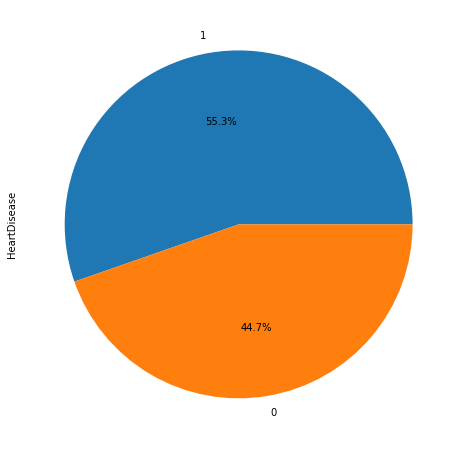

In [10]:
print(dataset["HeartDisease"].value_counts())
dataset["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(8,8));

### Conclusion:
Target label in dataset seems to be balanced with count of 508 of patients with heart failure and 410 patients without heart failure.

## 4) Duplicates Detection:

In [11]:
dataset.duplicated().value_counts()

False    918
dtype: int64

### Conclusion:
There are no duplicates records in our dataset and all of the 918 seem to be unique.

## 5) Outliers Detection and Handling:

In [63]:
numerical_features_boxplots = make_subplots(rows=3, cols=2, vertical_spacing=0.08, horizontal_spacing=0.4,
                    subplot_titles=("Boxplot of Age",
                                    "Boxplot of Resting Blood Pressure",
                                    "Boxplot of Cholesterol",
                                    "Boxplot of Maximum Heart Rate",
                                    "Boxplot of ST Segment Depression"))

numerical_features_boxplots.add_trace(go.Box(y=dataset['Age'], name="Age", 
                     marker_color = '#e05d59', showlegend=False),
              row=1, col=1)

numerical_features_boxplots.add_trace(go.Box(y=dataset['RestingBP'], name="RestingBP", 
                     marker_color = '#e0b659', showlegend=False),
              row=1, col=2)

numerical_features_boxplots.add_trace(go.Box(y=dataset['Cholesterol'], name="Cholesterol", 
                     marker_color = '#57de89', showlegend=False),
              row=2, col=1)

numerical_features_boxplots.add_trace(go.Box(y=dataset['MaxHR'], name="MaxHR", 
                     marker_color = '#5791de', showlegend=False),
              row=2, col=2)

numerical_features_boxplots.add_trace(go.Box(y=dataset['Oldpeak'], name="Oldpeak", 
                     marker_color = '#b971e3', showlegend=False),
              row=3, col=1)

numerical_features_boxplots.update_layout(
                  yaxis1_title='Age, in years',
                  yaxis2_title="Blood Pressure, mmHg",
                  yaxis3_title="Cholesterol, mg/dl",
                  yaxis4_title="Heart Rate, bpm",
                  yaxis5_title="ST Segment Depression, mm",
                  barmode='overlay', showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=.95),
                  height=1300, width=900)
numerical_features_boxplots.update_xaxes(showline=True, linewidth=1, linecolor='black', zeroline=False)
numerical_features_boxplots.update_yaxes(showline=False, zeroline=False)
numerical_features_boxplots.show()

### Observation:
Feature 'Age' does not show outliers. However, other features 'RestingBP', 'Cholesterol', 'MaxHR' and 'Oldpeak' show outliers.
### Action:
Outliers of each feature can be replaced either by:
- Option1: The mean value of this feature
- Option 2: Outliers below boxplot minimum can be replaced by it, and outliers above the boxplot maximum can be replaced by it.

After consulting Senior-Year Medicine Students, option 2 seemed more favorable for the meaning of these features and for the purpose of the application.

In [64]:
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1

for i in range(len(numerical_features_names)):
    replace_upper(dataset, numerical_features_names[i]) 
    
for i in range(len(numerical_features_names)):
    replace_lower(dataset, numerical_features_names[i])

In [65]:
numerical_features_boxplots = make_subplots(rows=3, cols=2, vertical_spacing=0.08, horizontal_spacing=0.4,
                    subplot_titles=("Boxplot of Age",
                                    "Boxplot of Resting Blood Pressure",
                                    "Boxplot of Cholesterol",
                                    "Boxplot of Maximum Heart Rate",
                                    "Boxplot of ST Segment Depression"))

numerical_features_boxplots.add_trace(go.Box(y=dataset['Age'], name="Age", 
                     marker_color = '#e05d59', showlegend=False),
              row=1, col=1)

numerical_features_boxplots.add_trace(go.Box(y=dataset['RestingBP'], name="RestingBP", 
                     marker_color = '#e0b659', showlegend=False),
              row=1, col=2)

numerical_features_boxplots.add_trace(go.Box(y=dataset['Cholesterol'], name="Cholesterol", 
                     marker_color = '#57de89', showlegend=False),
              row=2, col=1)

numerical_features_boxplots.add_trace(go.Box(y=dataset['MaxHR'], name="MaxHR", 
                     marker_color = '#5791de', showlegend=False),
              row=2, col=2)

numerical_features_boxplots.add_trace(go.Box(y=dataset['Oldpeak'], name="Oldpeak", 
                     marker_color = '#b971e3', showlegend=False),
              row=3, col=1)

numerical_features_boxplots.update_layout(
                  yaxis1_title='Age, in years',
                  yaxis2_title="Blood Pressure, mmHg",
                  yaxis3_title="Cholesterol, mg/dl",
                  yaxis4_title="Heart Rate, bpm",
                  yaxis5_title="ST Segment Depression, mm",
                  barmode='overlay', showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=.95),
                  height=1300, width=900)
numerical_features_boxplots.update_xaxes(showline=True, linewidth=1, linecolor='black', zeroline=False)
numerical_features_boxplots.update_yaxes(showline=False, zeroline=False)
numerical_features_boxplots.show()

### Conclusion:
All outliers are successfully handled since the boxplots of all features do not show any outliers for the same ranges.

## 6) Distribution of Numerical and Categorical Features:

### A) Numerical Features

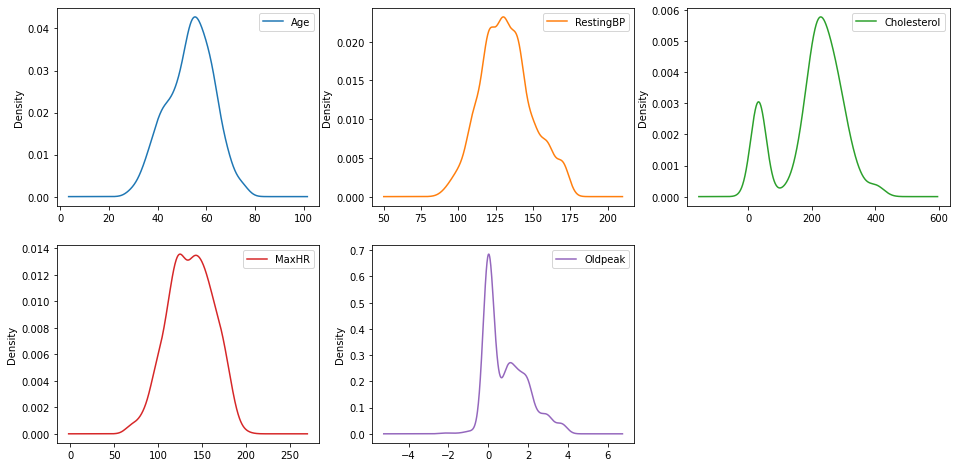

In [56]:
dataset[numerical_features_names].plot(kind='density', subplots=True, layout=(2,3), sharex=False, figsize= (16,8))
plt.show()


### B) Categorical Features

In [61]:
dataset[categorical_features_names].iplot(kind='histogram',subplots=True,bins=50)

### Conclusion:
- Since the numerical features seem normally distributed, we will use StandardScaler to scale them (Standardization).
- Since we cannot judge on the distribution of the categorical features as they do not have that many unique values, we wil use MinMaxScaler to scale them (Normalization).

# Data Visualization:

## 1) Histogram of Features between Classes:

In [165]:
numerical_features_histogram = make_subplots(rows=3, cols=2, vertical_spacing=0.1, horizontal_spacing=0.4,
                    subplot_titles=("Distribution of Age<br>by Heart Disease",
                                    "Distribution of Blood Pressure<br>by Heart Disease",
                                    "Distribution of Cholesterol<br>by Heart Disease",
                                    "Distribution of Maximum Heart Rate<br>by Heart Disease",
                                    "Distribution of ST Segment Depression<br>by Heart Disease"))

numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==1]['Age'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease"),
              row=1, col=1)
numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==0]['Age'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#000000')), 
                           opacity=0.75, name="No Disease"),
              row=1, col=1)

numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==1]['RestingBP'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
              row=1, col=2)
numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==0]['RestingBP'], histnorm='probability density',
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=1, col=2)

numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==1]['Cholesterol'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
             row=2, col=1)
numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==0]['Cholesterol'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=2, col=1)

numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==1]['MaxHR'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
             row=2, col=2)
numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==0]['MaxHR'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=2, col=2)

numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==1]['Oldpeak'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
             row=3, col=1)
numerical_features_histogram.add_trace(go.Histogram(x=dataset[dataset.HeartDisease==0]['Oldpeak'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=3, col=1)

numerical_features_histogram.update_layout(
                  xaxis1_title="Age, in years", yaxis1_title='Probability Density', 
                  xaxis2_title="Blood Pressure, mmHg", yaxis2_title='Probability Density', 
                  xaxis3_title="Cholesterol, mg/dl", yaxis3_title='Probability Density',
                  xaxis4_title="Heart Rate, bpm", yaxis4_title='Probability Density', 
                  xaxis5_title="ST Segment Depression, mm", yaxis5_title='Probability Density',
                  barmode='overlay', showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=0.65),
                  height=1300, width=900)

numerical_features_histogram.update_xaxes(showline=True, linewidth=1, linecolor='black', zeroline=False)
numerical_features_histogram.update_yaxes(showline=False, zeroline=False)
numerical_features_histogram.show()

### Observations:

- Age:

In patients with heart disease, there is a smaller spread with the majority of patients between the ages of 51 to 62.       
In patients without heart disease, there is a slightly wider variation in age that is more evenly distributed with the majority of patients within a younger age range of 43 to 57.           

- Systolic Blood Pressure:

The two groups are proportional with most patients' blood pressure in the range of 120 to 145 mmHg. The median blood pressure is about 130 mmHg in both groups.            

- Cholesterol:

The distribution of cholesterol appears to be skewed to the right, especially in patients with heart disease where there are a large number of observations missing cholesterol levels that were entered as 0 but were handled to be at value of 20 (minimum of range).          

- Heart Rate:     

Patients without heart disease are able to reach higher maximum heart rates than patients with heart disease, with a median heart rate of 150 beats per minute versus a median of 126 beats per minute in cardiovascular patients.

- ST Segment Depression (OldPeak):       

There is a notable difference in the distribution of ST segment depression between the groups. In patients with heart disease, there is more variability in ST depression with the majority having ST depressions between 0 to 2 mm with a median of 1.2 mm.                              
In patients without heart disease, the range is smaller comparatively, between 0 to 0.6 mm, with a median ST depression of 0 mm, although the distribution of this group exhibits more skewness overall.

In [162]:
# FastingBS Plot
p=dataset.groupby('FastingBS')['HeartDisease'].value_counts(normalize=True)
p=p.mul(100).rename('pct').reset_index().query('FastingBS==1')
x=p.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease').unique()

# ExcerciseAngina Plot
p2=dataset.groupby('ExerciseAngina')['HeartDisease'].value_counts(normalize=True)
p2=p2.mul(100).rename('pct').reset_index().query('ExerciseAngina=="Y"')
x2=p2.ExerciseAngina.apply(lambda x: 'Exercise Angina' if x=='Y' else 'No Angina').unique()

# RestingECG Plot
p3=dataset.groupby('RestingECG')['HeartDisease'].value_counts(normalize=True)
p3=p3.mul(100).rename('pct').reset_index()
x3=p3.RestingECG.unique()[::-1]
y5=p3[p3.HeartDisease==1]['pct'][::-1]
y6=p3[p3.HeartDisease==0]['pct'][::-1]

# Oldpeak Plot
p4=dataset.groupby('ST_Slope')['HeartDisease'].value_counts(normalize=True)
p4=p4.mul(100).rename('pct').reset_index()
x4=p4.ST_Slope.unique()
y7=p4[p4.HeartDisease==1]['pct']
y8=p4[p4.HeartDisease==0]['pct']

# ChestPainType Plot
p11=dataset.groupby('HeartDisease')['ChestPainType'].value_counts(normalize=True)
p11=p11.mul(100).rename('pct').reset_index()
x11=p11.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease').unique()[::-1]
y00=p11[p11.ChestPainType=='ASY']['pct'][::-1]
y11=p11[p11.ChestPainType=='NAP']['pct'][::-1]
y22=p11[p11.ChestPainType=='ATA']['pct'][::-1]
y33=p11[p11.ChestPainType=='TA']['pct'][::-1]

# Sex Plot
p22=dataset.groupby('HeartDisease')['Sex'].value_counts(normalize=True)
p22=p22.mul(100).rename('pct').reset_index()
x22=p22.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease').unique()[::-1]
y44=p22[p22.Sex=='M']['pct'][::-1]
y55=p22[p22.Sex=='F']['pct'][::-1]


fig1 = make_subplots(rows=3, cols=2, vertical_spacing=0.1, horizontal_spacing=0.1,
                    subplot_titles=("Prevalence of Heart Disease in<br>Patients with Diabetes",
                                    "Prevalence of Heart Disease in Patients<br>with Exercise Angina",
                                    "Prevalence of Heart Disease by Resting ECG",
                                    "Prevalence of Heart Disease by ST Slope",
                                    "Prevalence of Chest Pain in Heart Disease",
                                    "Gender Distribution in Heart Disease"))

# FastingBS Plot
fig1.add_trace(go.Bar(x=x, y=p.pct, name='Heart Disease', text=p.pct, textposition='outside',
                     texttemplate='%{text:.1f}%', width=.8, showlegend=False,
                     hovertemplate='Prevalence of %{x} among patients with Diabetes = %{y:.2f}%<extra></extra>',
                     marker=dict(color=['#AF4343', '#C6AA97'], opacity=0.8)), row=1,col=1) 

# ExcerciseAngina Plot
fig1.add_trace(go.Bar(x=x, y=p2.pct, name='Heart Disease', text=p2.pct, textposition='outside',
                     texttemplate='%{text:.1f}%', width=.8, showlegend=False,
                     hovertemplate='Prevalence of %{x} among patients with Exercise Angina = %{y:.2f}%<extra></extra>',
                     marker=dict(color=['#AF4343', '#C6AA97'], opacity=0.8)), row=1,col=2)
# RestingECG Plot
fig1.add_trace(go.Bar(x=x3, y=y5, name='Heart Disease', text=y5, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, 
                     hovertemplate='Proportion of Heart Disease in patients with %{x} ECG = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)), row=2,col=1)
fig1.add_trace(go.Bar(x=x3, y=y6, name='No Disease', text=y6, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, 
                     hovertemplate='Proportion of Non-Cardiovascular patients with %{x} ECG = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)), row=2,col=1)

# Oldpeak Plot
fig1.add_trace(go.Bar(x=x4, y=y7, name='Heart Disease', text=y7, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, showlegend=False,
                     hovertemplate='Proportion of Heart Disease in patients with %{x} ST Slope = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)), row=2,col=2)
fig1.add_trace(go.Bar(x=x4, y=y8, name='No Disease', text=y8, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, showlegend=False,
                     hovertemplate='Proportion of Non-Cardiovascular patients with %{x} ST Slope = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)), row=2,col=2)

# ChestPainType Plot
fig1.append_trace(go.Bar(x=x11, y=y00, name='Asymptomatic', text=y00, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Asymptomatic Chest Pain in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#E5BAB4', opacity=0.8)), row=3,col=1) #E2C3B5
fig1.append_trace(go.Bar(x=x11, y=y11, name='Non-Anginal Pain', text=y11, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Non-Anginal Pain in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#BE6B6B', opacity=0.8)), row=3,col=1)
fig1.append_trace(go.Bar(x=x11, y=y22, name='Atypical Angina', text=y22, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Atypical Angina in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#C1D2D1', opacity=0.8)), row=3,col=1)
fig1.append_trace(go.Bar(x=x11, y=y33, name='Typical Angina', text=y33, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Typical Angina in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#598885', opacity=0.8)), row=3,col=1)
# Sex Plot
fig1.append_trace(go.Bar(x=x22, y=y44, name='Men', text=y44, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.4, legendgroup = '2',
                     hovertemplate='Proportion of %{x} among Men = %{y:.2f}%',
                     marker=dict(color='#646782', opacity=0.8)), row=3,col=2)
fig1.append_trace(go.Bar(x=x22, y=y55, name='Women', text=y55, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.4, legendgroup = '2',
                     hovertemplate='Proportion of %{x} among Women = %{y:.2f}%',
                     marker=dict(color='#CDD5DE', opacity=0.8)), row=3,col=2)

fig1.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig1.update_layout(showlegend=True,
                  barmode='group', bargap=.15, height=900, width=1000,
                  legend=dict(orientation="h", yanchor="bottom", y=1.1, xanchor="right", x=0.75),
                  yaxis1_range=[0,99], yaxis1_ticksuffix='%',
                  yaxis2_range=[0,99], yaxis2_ticksuffix='%',
                  yaxis3_range=[0,95], yaxis3_ticksuffix='%',
                  yaxis4_range=[0,99], yaxis4_ticksuffix='%',
                  yaxis5_range=[0,90], yaxis5_ticksuffix='%',
                  yaxis6_range=[0,99], yaxis6_ticksuffix='%')

fig1.show()

### Observations:

- Fasting Blood Sugar:

Patients with fasting blood sugar more than 120 ml/dl are way more likely to have heart failure.

- Exercise-induced Angina:

Clear differences among the chest pain type can be observed: Person with ASY (Asymptomatic chest pain) has almost 6 times more likely have a heart disease than person with ATA Atypical Angina chest pain.

- Resting ECG:

Resting electrocardiogram results do not differ much.

- ST Slope:

In ST-Slope, Up significantly less likely has heart disease than the other two segment.

- Chest Pain Type:

Exercise-induced angina with 'Yes' almost 2.4 times more likley have a heart disaese than exercise-induced angina with 'No'.

- Sex:

Based on the gender; Men are almost 2.44 times more likely have a heart disease than women.

## B) Pair Plot of Features:

<Figure size 864x720 with 0 Axes>

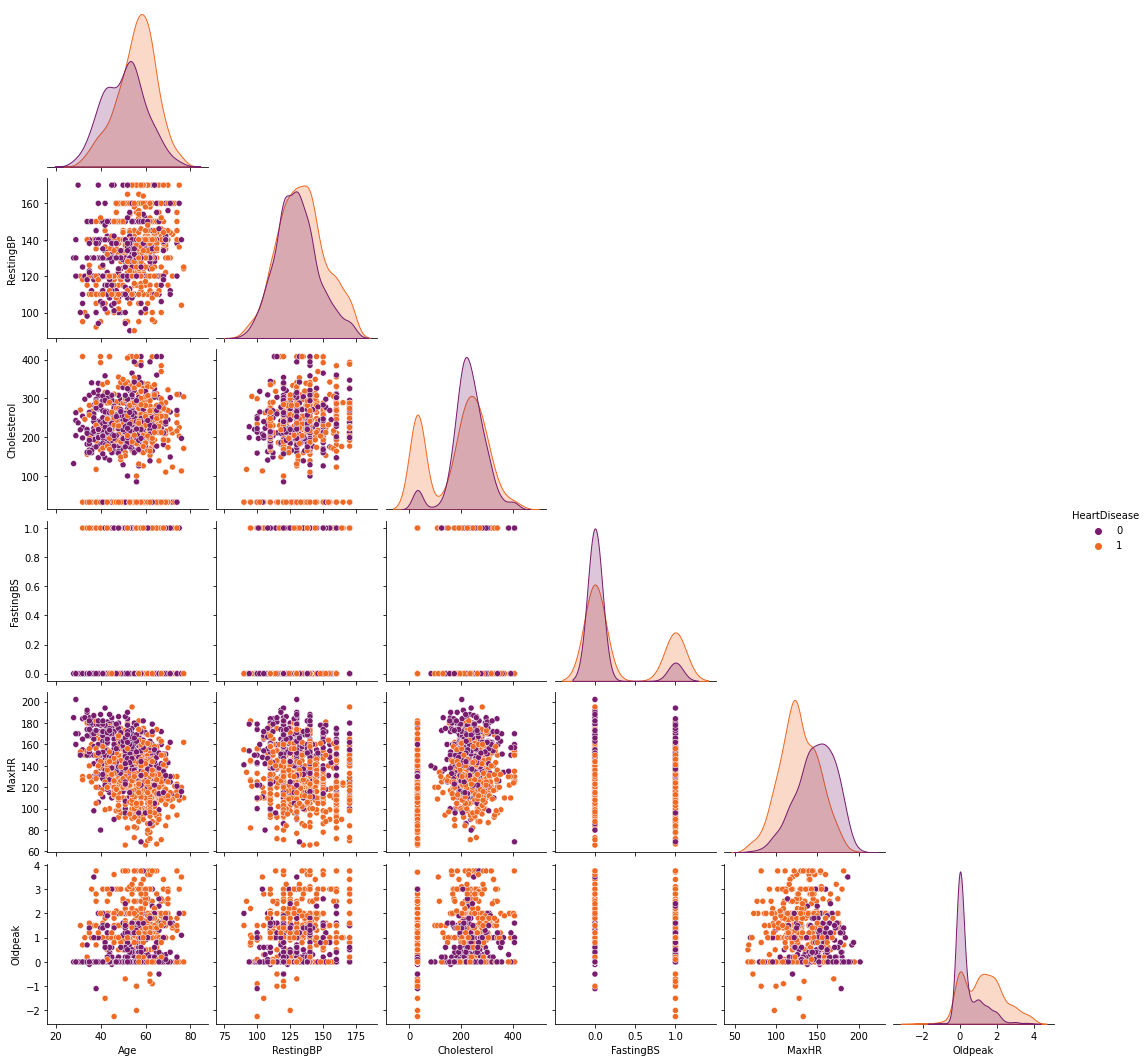

In [168]:
plt.figure(figsize=(12, 10))
sns.pairplot(dataset, hue="HeartDisease", palette="inferno", corner=True);

## C) Correlation between Features:

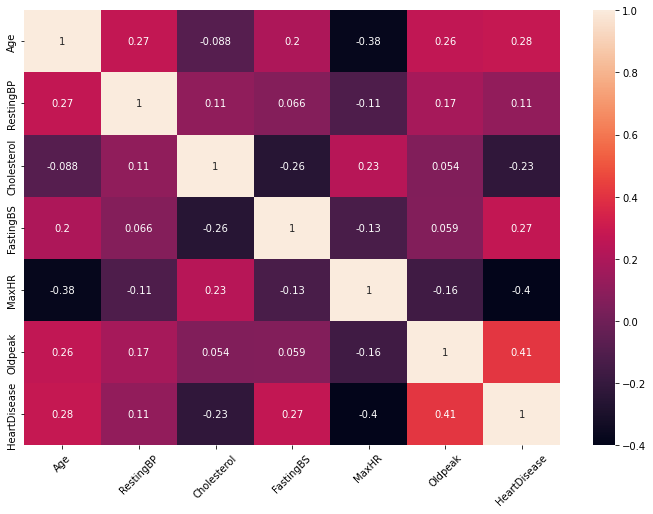

In [170]:
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True)
plt.xticks(rotation=45);

### Observations:

- HeartDisease has the strongest positive association to OldPeak (correlation = 0.41) and the strongest negative association to MaxHR (correlation = -0.4).                             
- There is a moderately strong relationship between Age and MaxHR of -0.38. As age increases, heart rate tends to decrease.                
- Interestingly cholesterol has negative correlation with the heart disease.
- In general, there is weak level correlation between the numerical features and the target variable

# Feature Scaling

### A) Quantization of Categorical Features:

In [173]:
lab_encoder = LabelEncoder() 
dataset[categorical_features_names] = dataset[categorical_features_names].apply(lambda col: lab_encoder.fit_transform(col)) 
dataset.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289.0,0,1,172,0,0.0,2,0
1,49,0,2,160,180.0,0,1,156,0,1.0,1,1
2,37,1,1,130,283.0,0,2,98,0,0.0,2,0
3,48,0,0,138,214.0,0,1,108,1,1.5,1,1
4,54,1,2,150,195.0,0,1,122,0,0.0,2,0


### B) Dataset Splitting into Training, Validation and Testing:

In [184]:
X_features_1 = dataset.drop("HeartDisease", axis = 1)
y_target_1 = dataset['HeartDisease']

# Making another copy of dataset
X_features_2 = copy.deepcopy(X_features_1)
y_target_2 = dataset['HeartDisease']

# Splitting first copy of features into training (60%), validation (20% & 10%) and testing (10%)
X_learn_1, X_test_1, y_learn_1, y_test_1 = train_test_split(X_features_1, y_target_1, random_state =100 ,stratify=y_target_1, train_size = 0.9, test_size = 0.1)
X_train_1, X_validate_1, y_train_1, y_validate_1 = train_test_split(X_learn_1, y_learn_1, random_state =100 ,stratify=y_learn_1, train_size = 0.67, test_size = 0.33)
X_validate_1_A, X_validate_1_B, y_validate_1_A, y_validate_1_B = train_test_split(X_validate_1, y_validate_1, random_state =100 ,stratify=y_validate_1, train_size = 0.67, test_size = 0.33)

# Splitting Second copy of features into training (60%), validation (20% & 10%) and testing (10%)
X_learn_2, X_test_2, y_learn_2, y_test_2 = train_test_split(X_features_2, y_target_2, random_state =100 ,stratify=y_target_2, train_size = 0.9, test_size = 0.1)
X_train_2, X_validate_2, y_train_2, y_validate_2 = train_test_split(X_learn_2, y_learn_2, random_state =100 ,stratify=y_learn_2, train_size = 0.67, test_size = 0.33)
X_validate_2_A, X_validate_2_B, y_validate_2_A, y_validate_2_B = train_test_split(X_validate_2, y_validate_2, random_state =100 ,stratify=y_validate_2, train_size = 0.67, test_size = 0.33)

print('First Copy of Features')
print('Training Records: ', X_train_1.shape[0], ', % of Training Records: ', round((X_train_1.shape[0]/918)*100))
print('Validation A Records: ', X_validate_1_A.shape[0], ', % of Validation A Records: ', round((X_validate_1_A.shape[0]/918)*100))
print('Validation B Records: ', X_validate_1_B.shape[0], ', % of Validation B Records: ', round((X_validate_1_B.shape[0]/918)*100))
print('Testing Records: ', X_test_1.shape[0], ', % of Testing Records: ', round((X_test_1.shape[0]/918)*100))
print('\n')

print('Second Copy of Features')
print('Training Records: ', X_train_2.shape[0], ', % of Training Records: ', round((X_train_2.shape[0]/918)*100))
print('Validation A Records: ', X_validate_2_A.shape[0], ', % of Validation A Records: ', round((X_validate_2_A.shape[0]/918)*100))
print('Validation B Records: ', X_validate_2_B.shape[0], ', % of Validation B Records: ', round((X_validate_2_B.shape[0]/918)*100))
print('Testing Records: ', X_test_2.shape[0], ', % of Testing Records: ', round((X_test_2.shape[0]/918)*100))

First Copy of Features
Training Records:  553 , % of Training Records:  60
Validation A Records:  182 , % of Validation A Records:  20
Validation B Records:  91 , % of Validation B Records:  10
Testing Records:  92 , % of Testing Records:  10


Second Copy of Features
Training Records:  553 , % of Training Records:  60
Validation A Records:  182 , % of Validation A Records:  20
Validation B Records:  91 , % of Validation B Records:  10
Testing Records:  92 , % of Testing Records:  10


#### Subdatasets Information Summary:

- *Training Dataset:* Contains 553 records, forming 60% of dataset and will be used for training.             
- *Validate A Dataset:* Contains 182 records, forming 20% of dataset and will be used for decision of best hyperparameters.            
- *Validate B Dataset:* Contains 91 records, forming 10% of dataset and will be used for decision of best model.               
- *Testing Dataset:* Contains 92 records, forming 10% of dataset and will be used for confirmation for decisions taken in validation stage. 

#### Reason for Making 2 Copies of Dataset:

- *First Copy:* is to be used for Distance-Based Models (SVM and KNN), and will be scaled.
- *Second Copy:* is to be used for Tree-Based Models (DT and RF), and will not be scaled.


- *Distance Based Algorithms :*

Distance algorithms like "KNN" and "SVM" are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity. When two features have different scales, there is a chance that higher weightage is given to features with higher magnitude. This will impact the performance of the machine learning algorithm and we do not want our algorithm to be biased towards one feature.                   
Therefore, we scale our data before employing a distance based algorithm so that all the features contribute equally to the result.

- *Tree-Based Algorithms :*

Tree-based algorithms, on the other hand, are fairly insensitive to the scale of the features. For example, a decision tree is only splitting a node based on a single feature. The decision tree splits a node on a feature that increases the homogeneity of the node. This split on a feature is not influenced by other features.                         
Therefore, there is virtually no effect of the remaining features on the split. This is what makes them invariant to the scale of the features, and we do not have to scale our data before employing a tree-based algorithm since it will have no use whatsoever.


### C) Feature Scaling Step:

In [185]:
# Scaling first copy of dataset

# Using MinMaxScaler for categorical features
min_max_scaler_for_training_and_testing = MinMaxScaler()
min_max_scaler_for_validation_A_and_B = MinMaxScaler()

X_train_1[categorical_features_names] = min_max_scaler_for_training_and_testing.fit_transform(X_train_1[categorical_features_names])
X_test_1[categorical_features_names] = min_max_scaler_for_training_and_testing.transform(X_test_1[categorical_features_names])

X_validate_1_A[categorical_features_names] = min_max_scaler_for_validation_A_and_B.fit_transform(X_validate_1_A[categorical_features_names])
X_validate_1_B[categorical_features_names] = min_max_scaler_for_validation_A_and_B.transform(X_validate_1_B[categorical_features_names])

# Using StandardScaler for numerical features
standard_scaler_for_training_and_testing = StandardScaler()
standard_scaler_for_validation_A_and_B = StandardScaler()

X_train_1[numerical_features_names] = standard_scaler_for_training_and_testing.fit_transform(X_train_1[numerical_features_names])
X_test_1[numerical_features_names] = standard_scaler_for_training_and_testing.transform(X_test_1[numerical_features_names])

X_validate_1_A[numerical_features_names] = standard_scaler_for_validation_A_and_B.fit_transform(X_validate_1_A[numerical_features_names])
X_validate_1_B[numerical_features_names] = standard_scaler_for_validation_A_and_B.transform(X_validate_1_B[numerical_features_names])


#### Note:
We have scaled the categorical features using *MinMaxScaler* and the numerical features using *StandardScaler*, as discussed in *General Preprocessing* Section: *Distribution of Numerical and Categorical Features*

# Feature Selection/Extraction

### Two Pipelines of Different Feature Extraction Techniques:
Choices of hyperparameters and model decision will be  performed on validation dataset using Principal Component Analysis and Backward Sequential Feature Selection:     

1) *Backward Sequential Feature Selection (Feature Selector):*

+ It takes target into consideration and relies on relationship between it and the features.
+ It uses subset of same features, not linear combination, relying on an estimator, so result is heavily effected with change of estimator and its hyperparameters.
 
 
2) *Principal Component Analysis (Feature Extractor):*

+ It relies on linear relationship between feature elements.
+ It will lead to good results if there strong linear relationship between features and there can be much information in smaller number of features, and fails if either of these assumptions are not true.


## A) Backward Sequential Feature Selection:

### 1) Performing Backward SFS:

In [195]:
best_features_for_SVM, best_score_for_SVM = None, 0
for number_of_features in range(1,12):
    sfs = SFS(SVC(), k_features = number_of_features, forward= False, n_jobs= -1).fit(X_validate_1_A, y_validate_1_A)
    if sfs.k_score_ >= best_score_for_SVM:
        best_features_for_SVM, best_score_for_SVM = sfs.k_feature_names_, sfs.k_score_
    
print("SVM Best features: ",list(best_features_for_SVM))
print("SVM Best score: ",best_score_for_SVM )
print('\n')

best_features_for_KNN, best_score_for_KNN = None, 0
for number_of_features in range(1,12):
    sfs = SFS(KNeighborsClassifier(), k_features = number_of_features, forward= False, n_jobs= -1).fit(X_validate_1_A, y_validate_1_A)
    if sfs.k_score_ >= best_score_for_KNN:
        best_features_for_KNN, best_score_for_KNN = sfs.k_feature_names_, sfs.k_score_
    
print("KNN Best features: ",list(best_features_for_KNN))
print("KNN Best score: ",best_score_for_KNN )
print('\n')

best_features_for_DT, best_score_for_DT = None, 0
for number_of_features in range(1,12):
    sfs = SFS(DecisionTreeClassifier(), k_features = number_of_features, forward= False, n_jobs= -1).fit(X_validate_2_A, y_validate_2_A)
    if sfs.k_score_ >= best_score_for_DT:
        best_features_for_DT, best_score_for_DT = sfs.k_feature_names_, sfs.k_score_
        
print("DT Best features: ",list(best_features_for_DT))
print("DT Best score: ",best_score_for_DT )
print('\n')
        
best_features_for_RF, best_score_for_RF = None, 0
for number_of_features in range(1,12):
    sfs = SFS(RandomForestClassifier(), k_features = number_of_features, forward= False, n_jobs= -1).fit(X_validate_2_A, y_validate_2_A)
    if sfs.k_score_ >= best_score_for_RF:
        best_features_for_RF, best_score_for_RF = sfs.k_feature_names_, sfs.k_score_
    
print("RF Best features: ",list(best_features_for_RF))
print("RF Best score: ",best_score_for_RF )
print('\n')

SVM Best features:  ['ExerciseAngina', 'ST_Slope']
SVM Best score:  0.867867867867868


KNN Best features:  ['Cholesterol', 'ST_Slope']
KNN Best score:  0.8348348348348349


DT Best features:  ['Sex', 'ChestPainType', 'Cholesterol', 'FastingBS', 'MaxHR', 'ST_Slope']
DT Best score:  0.8623123123123122


RF Best features:  ['ChestPainType', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
RF Best score:  0.868018018018018




### 2) GridSearchCV for Best Hyperparameters:

In [204]:
X_validate_A_for_SVM = X_validate_1_A[list(best_features_for_SVM)]
X_validate_A_for_KNN = X_validate_1_A[list(best_features_for_KNN)]
X_validate_A_for_DT = X_validate_2_A[list(best_features_for_DT)]
X_validate_A_for_RF = X_validate_2_A[list(best_features_for_RF)]


SVM_parameters = {'kernel' : ('linear','poly', 'rbf', 'sigmoid'),
                  'C':[0, 1, 1, 10, 100, 1000],
                  'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001]}

KNN_parameters = {'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'p': [1, 2],
                  'weights': ['uniform', 'distance'],
                  'n_neighbors': range(1, 30)}

DT_parameters = {"criterion": ['gini', 'entropy'], 
                 "splitter":["best", "random"],
                 "max_features":[None, 3, 5, 7],
                 "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
                 "min_samples_leaf": [1, 2, 3, 4, 5],
                 "min_samples_split": [2, 3, 5, 7, 9, 10, 15]}

RF_parameters = {'max_features':[2, 3, 4],
                 'max_depth':[3, 5, 7, 9],
                 'min_samples_split':[2, 5, 8],
                 'min_samples_leaf':[3, 5, 7],
                 'criterion': ['gini', 'entropy']}


grid_search_cv_for_SVM = GridSearchCV(SVC(), SVM_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_A_for_SVM, y_validate_1_A)
print('Best parameters for SVM: ', grid_search_cv_for_SVM.best_params_)
print('Best score for SVM: ', grid_search_cv_for_SVM.best_score_)
print('\n')

grid_search_cv_for_KNN = GridSearchCV(KNeighborsClassifier(), KNN_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_A_for_KNN, y_validate_1_A)
print('Best parameters for KNN: ', grid_search_cv_for_KNN.best_params_)
print('Best score for KNN: ', grid_search_cv_for_KNN.best_score_)
print('\n')

grid_search_cv_for_DT = GridSearchCV(DecisionTreeClassifier(), DT_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_A_for_DT, y_validate_2_A)
print('Best parameters for DT: ', grid_search_cv_for_DT.best_params_)
print('Best score for DT: ', grid_search_cv_for_DT.best_score_)
print('\n')

grid_search_cv_for_RF = GridSearchCV(RandomForestClassifier(), RF_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_A_for_RF, y_validate_2_A)
print('Best parameters for RF: ', grid_search_cv_for_RF.best_params_)
print('Best score for RF: ', grid_search_cv_for_RF.best_score_)
print('\n')

C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


280 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.f

Best parameters for SVM:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM:  0.867251461988304


Best parameters for KNN:  {'algorithm': 'auto', 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
Best score for KNN:  0.8511695906432749




C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


11200 fits failed out of a total of 44800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\tree\_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]

Best parameters for DT:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'splitter': 'random'}
Best score for DT:  0.8789473684210526


Best parameters for RF:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 8}
Best score for RF:  0.878654970760234




### 3) Validating Models:

In [209]:
SVM_model_for_validation = SVC(C= 1, gamma= 'scale', kernel= 'rbf')
KNN_model_for_validation = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 13, p= 1, weights= 'uniform')
DT_model_for_validation = DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, max_features= None, min_samples_leaf= 1, min_samples_split= 9, splitter= 'random')
RF_model_for_validation = RandomForestClassifier(criterion= 'entropy', max_depth= 7, max_features= 2, min_samples_leaf= 5, min_samples_split= 8)

SVM_model_for_validation.fit(X_validate_A_for_SVM, y_validate_1_A)
KNN_model_for_validation.fit(X_validate_A_for_KNN, y_validate_1_A)
DT_model_for_validation.fit(X_validate_A_for_DT, y_validate_2_A)
RF_model_for_validation.fit(X_validate_A_for_RF, y_validate_2_A)


X_validate_B_for_SVM = X_validate_1_B[list(best_features_for_SVM)]
X_validate_B_for_KNN = X_validate_1_B[list(best_features_for_KNN)]
X_validate_B_for_DT = X_validate_2_B[list(best_features_for_DT)]
X_validate_B_for_RF = X_validate_2_B[list(best_features_for_RF)]


# SVM validation scores
y_learn_pred_SVM = SVM_model_for_validation.predict(X_validate_A_for_SVM)
y_validate_pred_SVM = SVM_model_for_validation.predict(X_validate_B_for_SVM)

train_acc_SVM = accuracy_score(y_validate_1_A, y_learn_pred_SVM)
test_acc_SVM = accuracy_score(y_validate_1_B, y_validate_pred_SVM)
f1_score_SVM = f1_score(y_validate_1_B, y_validate_pred_SVM)
recall_score_SVM = recall_score(y_validate_1_B, y_validate_pred_SVM)

cv_scores_SVM_using_accuracy = cross_val_score(SVM_model_for_validation, X_validate_B_for_SVM , y_validate_1_B , cv = 10, scoring = 'accuracy' )
cv_scores_SVM_using_f1 = cross_val_score(SVM_model_for_validation, X_validate_B_for_SVM , y_validate_1_B , cv = 10, scoring = 'f1' )
cv_scores_SVM_using_recall = cross_val_score(SVM_model_for_validation, X_validate_B_for_SVM , y_validate_1_B , cv = 10, scoring = 'recall' )

# KNN validation scores
y_learn_pred_KNN = KNN_model_for_validation.predict(X_validate_A_for_KNN)
y_validate_pred_KNN = KNN_model_for_validation.predict(X_validate_B_for_KNN)

train_acc_KNN = accuracy_score(y_validate_1_A, y_learn_pred_KNN)
test_acc_KNN = accuracy_score(y_validate_1_B, y_validate_pred_KNN)
f1_score_KNN = f1_score(y_validate_1_B, y_validate_pred_KNN)
recall_score_KNN = recall_score(y_validate_1_B, y_validate_pred_KNN)

cv_scores_KNN_using_accuracy = cross_val_score(KNN_model_for_validation, X_validate_B_for_KNN , y_validate_1_B , cv = 10, scoring = 'accuracy' )
cv_scores_KNN_using_f1 = cross_val_score(KNN_model_for_validation, X_validate_B_for_KNN , y_validate_1_B , cv = 10, scoring = 'f1' )
cv_scores_KNN_using_recall = cross_val_score(KNN_model_for_validation, X_validate_B_for_KNN , y_validate_1_B , cv = 10, scoring = 'recall' )

# DT validation scores
y_learn_pred_DT = DT_model_for_validation.predict(X_validate_A_for_DT)
y_validate_pred_DT = DT_model_for_validation.predict(X_validate_B_for_DT)

train_acc_DT = accuracy_score(y_validate_2_A, y_learn_pred_DT)
test_acc_DT = accuracy_score(y_validate_2_B, y_validate_pred_DT)
f1_score_DT = f1_score(y_validate_2_B, y_validate_pred_DT)
recall_score_DT = recall_score(y_validate_2_B, y_validate_pred_DT)

cv_scores_DT_using_accuracy = cross_val_score(DT_model_for_validation, X_validate_B_for_DT , y_validate_2_B , cv = 10, scoring = 'accuracy' )
cv_scores_DT_using_f1 = cross_val_score(DT_model_for_validation, X_validate_B_for_DT , y_validate_2_B , cv = 10, scoring = 'f1' )
cv_scores_DT_using_recall = cross_val_score(DT_model_for_validation, X_validate_B_for_DT , y_validate_2_B , cv = 10, scoring = 'recall' )

# RF validation scores
y_learn_pred_RF = RF_model_for_validation.predict(X_validate_A_for_RF)
y_validate_pred_RF = RF_model_for_validation.predict(X_validate_B_for_RF)

train_acc_RF = accuracy_score(y_validate_2_A, y_learn_pred_RF)
test_acc_RF = accuracy_score(y_validate_2_B, y_validate_pred_RF)
f1_score_RF = f1_score(y_validate_2_B, y_validate_pred_RF)
recall_score_RF = recall_score(y_validate_2_B, y_validate_pred_RF)

cv_scores_RF_using_accuracy = cross_val_score(RF_model_for_validation, X_validate_B_for_RF , y_validate_2_B , cv = 10, scoring = 'accuracy' )
cv_scores_RF_using_f1 = cross_val_score(RF_model_for_validation, X_validate_B_for_RF , y_validate_2_B , cv = 10, scoring = 'f1' )
cv_scores_RF_using_recall = cross_val_score(RF_model_for_validation, X_validate_B_for_RF , y_validate_2_B , cv = 10, scoring = 'recall' )


# Matrix of scores
compare_models = [('Support Vector Machine', train_acc_SVM, test_acc_SVM, f1_score_SVM, recall_score_SVM),
                  ('K-Nearest Neighbor', train_acc_KNN, test_acc_KNN, f1_score_KNN, recall_score_KNN),
                  ('Decision Tree', train_acc_DT, test_acc_DT, f1_score_DT, recall_score_DT),
                  ('Random Forest', train_acc_RF, test_acc_RF, f1_score_RF, recall_score_RF)]

predict = pd.DataFrame(data = compare_models, columns=['Model', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'Recall'])
predict.style.background_gradient(cmap='YlGn')

,Model,Training Accuracy,Testing Accuracy,F1-Score,Recall
0,Support Vector Machine,0.868132,0.846154,0.860000,0.860000
1,K-Nearest Neighbor,0.851648,0.868132,0.886792,0.940000
2,Decision Tree,0.890110,0.857143,0.865979,0.840000
3,Random Forest,0.884615,0.901099,0.910891,0.920000


In [210]:
# Boxplot of cross-validation scores:

# SVM
cv_scores_SVM_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_SVM_using_accuracy, 'Metric': 'Accuracy', 'Model': 'Support Vector Machine'})
cv_scores_SVM_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_SVM_using_f1, 'Metric': 'F1', 'Model': 'Support Vector Machine'})
cv_scores_SVM_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_SVM_using_recall, 'Metric': 'Recall', 'Model': 'Support Vector Machine'})
SVM_dataframe = pd.concat([cv_scores_SVM_using_accuracy_dict, cv_scores_SVM_using_f1_dict, cv_scores_SVM_using_recall_dict], axis=0)

# KNN
cv_scores_KNN_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_KNN_using_accuracy, 'Metric': 'Accuracy', 'Model': 'K-Nearest Neighbor'})
cv_scores_KNN_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_KNN_using_f1, 'Metric': 'F1', 'Model': 'K-Nearest Neighbor'})
cv_scores_KNN_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_KNN_using_recall, 'Metric': 'Recall', 'Model': 'K-Nearest Neighbor'})
KNN_dataframe = pd.concat([cv_scores_KNN_using_accuracy_dict, cv_scores_KNN_using_f1_dict, cv_scores_KNN_using_recall_dict], axis=0)

# DT
cv_scores_DT_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_DT_using_accuracy, 'Metric': 'Accuracy', 'Model': 'Decision Tree'})
cv_scores_DT_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_DT_using_f1, 'Metric': 'F1', 'Model': 'Decision Tree'})
cv_scores_DT_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_DT_using_recall, 'Metric': 'Recall', 'Model': 'Decision Tree'})
DT_dataframe = pd.concat([cv_scores_DT_using_accuracy_dict, cv_scores_DT_using_f1_dict, cv_scores_DT_using_recall_dict], axis=0)

# RF
cv_scores_RF_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_RF_using_accuracy, 'Metric': 'Accuracy', 'Model': 'Random Forest'})
cv_scores_RF_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_RF_using_f1, 'Metric': 'F1', 'Model': 'Random Forest'})
cv_scores_RF_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_RF_using_recall, 'Metric': 'Recall', 'Model': 'Random Forest'})
RF_dataframe = pd.concat([cv_scores_RF_using_accuracy_dict, cv_scores_RF_using_f1_dict, cv_scores_RF_using_recall_dict], axis=0)


plot_df=pd.concat([SVM_dataframe, KNN_dataframe, DT_dataframe, RF_dataframe], axis=0)
plot_df['Score']=plot_df.Score.mul(100)
fig = px.box(plot_df, x="Model", y="Score", color="Metric", 
             title="Model Performance on the Validation Set",
             color_discrete_sequence = ['#45c7af', '#95C8C3','#45968E'])
fig.update_layout(xaxis_title='Model', yaxis_ticksuffix='%')
fig.update_xaxes(categoryorder='median descending')
fig.show()

## 2) Principal Component Analysis:

### 1) Choosing Best Number of PCs:

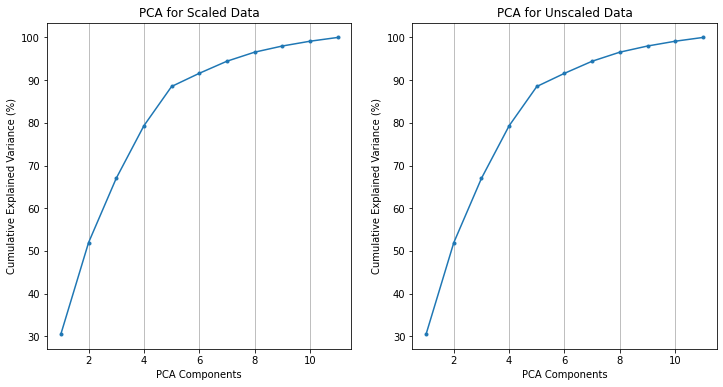

In [231]:
X_validate_1_A_for_transformation = copy.deepcopy(X_validate_1_A)
X_validate_2_A_for_transformation = copy.deepcopy(X_validate_2_A)

pca_for_scaled_data = PCA()
pca_for_scaled_data.fit_transform(X_validate_1_A_for_transformation);
cum_sum_1 = np.cumsum(pca_for_scaled_data.explained_variance_ratio_)*100
comp_1= [n for n in range(1, (len(cum_sum_1))+1)]

pca_for_unscaled_data = PCA()
pca_for_unscaled_data.fit_transform(X_validate_2_A_for_transformation);
cum_sum_2 = np.cumsum(pca_for_unscaled_data.explained_variance_ratio_)*100
comp_2= [n for n in range(1, (len(cum_sum_2))+1)]

figure, axes = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(comp_1, cum_sum_1, marker='.')
plt.grid(axis='x')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA for Scaled Data')

plt.subplot(1, 2, 2)
plt.plot(comp_1, cum_sum_1, marker='.')
plt.grid(axis='x')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA for Unscaled Data')

plt.show()

### 2) Data Transformation:

In [233]:
X_validate_1_A_for_transformation = copy.deepcopy(X_validate_1_A)
X_validate_1_B_for_transformation = copy.deepcopy(X_validate_1_B)

X_validate_2_A_for_transformation = copy.deepcopy(X_validate_2_A)
X_validate_2_B_for_transformation = copy.deepcopy(X_validate_2_B)

pca_for_scaled_data = PCA(n_components = 5)
pca_for_scaled_data.fit_transform(X_validate_1_A_for_transformation);
pca_for_scaled_data.transform(X_validate_1_B_for_transformation);

pca_for_unscaled_data = PCA(n_components = 5)
pca_for_unscaled_data.fit_transform(X_validate_2_A_for_transformation);
pca_for_unscaled_data.transform(X_validate_2_B_for_transformation);

### 3) GridSearch for Best Hyperparameters:

In [234]:
grid_search_cv_for_SVM = GridSearchCV(SVC(), SVM_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_1_A_for_transformation, y_validate_1_A)
print('Best parameters for SVM: ', grid_search_cv_for_SVM.best_params_)
print('Best score for SVM: ', grid_search_cv_for_SVM.best_score_)
print('\n')

grid_search_cv_for_KNN = GridSearchCV(KNeighborsClassifier(), KNN_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_1_A_for_transformation, y_validate_1_A)
print('Best parameters for KNN: ', grid_search_cv_for_KNN.best_params_)
print('Best score for KNN: ', grid_search_cv_for_KNN.best_score_)
print('\n')

grid_search_cv_for_DT = GridSearchCV(DecisionTreeClassifier(), DT_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_2_A_for_transformation, y_validate_2_A)
print('Best parameters for DT: ', grid_search_cv_for_DT.best_params_)
print('Best score for DT: ', grid_search_cv_for_DT.best_score_)
print('\n')

grid_search_cv_for_RF = GridSearchCV(RandomForestClassifier(), RF_parameters, scoring=['accuracy','f1_macro', 'recall'], refit='accuracy', cv=10).fit(X_validate_2_A_for_transformation, y_validate_2_A)
print('Best parameters for RF: ', grid_search_cv_for_RF.best_params_)
print('Best score for RF: ', grid_search_cv_for_RF.best_score_)
print('\n')

C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


280 fits failed out of a total of 1680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.f

Best parameters for SVM:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score for SVM:  0.8400584795321638


Best parameters for KNN:  {'algorithm': 'auto', 'n_neighbors': 18, 'p': 1, 'weights': 'distance'}
Best score for KNN:  0.8456140350877194


Best parameters for DT:  {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Best score for DT:  0.8953216374269006


Best parameters for RF:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score for RF:  0.8730994152046783




### 4) Validating Models:

In [236]:
SVM_model_for_validation_after_transformation = SVC(C= 1, gamma= 0.1, kernel= 'rbf')
KNN_model_for_validation_after_transformation = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 18, p= 1, weights= 'distance')
DT_model_for_validation_after_transformation = DecisionTreeClassifier(criterion= 'gini', max_depth= 4, max_features= None, min_samples_leaf= 2, min_samples_split= 10, splitter= 'random')
RF_model_for_validation_after_transformation = RandomForestClassifier(criterion= 'entropy', max_depth= 3, max_features= 3, min_samples_leaf= 5, min_samples_split= 2)

SVM_model_for_validation_after_transformation.fit(X_validate_1_A_for_transformation, y_validate_1_A)
KNN_model_for_validation_after_transformation.fit(X_validate_1_A_for_transformation, y_validate_1_A)
DT_model_for_validation_after_transformation.fit(X_validate_2_A_for_transformation, y_validate_2_A)
RF_model_for_validation_after_transformation.fit(X_validate_2_A_for_transformation, y_validate_2_A)


# SVM validation scores
y_learn_pred_SVM = SVM_model_for_validation_after_transformation.predict(X_validate_1_A_for_transformation)
y_validate_pred_SVM = SVM_model_for_validation_after_transformation.predict(X_validate_1_B_for_transformation)

train_acc_SVM = accuracy_score(y_validate_1_A, y_learn_pred_SVM)
test_acc_SVM = accuracy_score(y_validate_1_B, y_validate_pred_SVM)
f1_score_SVM = f1_score(y_validate_1_B, y_validate_pred_SVM)
recall_score_SVM = recall_score(y_validate_1_B, y_validate_pred_SVM)

cv_scores_SVM_using_accuracy = cross_val_score(SVM_model_for_validation_after_transformation, X_validate_1_B_for_transformation, y_validate_1_B , cv = 10, scoring = 'accuracy' )
cv_scores_SVM_using_f1 = cross_val_score(SVM_model_for_validation_after_transformation, X_validate_1_B_for_transformation, y_validate_1_B , cv = 10, scoring = 'f1' )
cv_scores_SVM_using_recall = cross_val_score(SVM_model_for_validation_after_transformation, X_validate_1_B_for_transformation, y_validate_1_B , cv = 10, scoring = 'recall' )

# KNN validation scores
y_learn_pred_KNN = KNN_model_for_validation_after_transformation.predict(X_validate_1_A_for_transformation)
y_validate_pred_KNN = KNN_model_for_validation_after_transformation.predict(X_validate_1_B_for_transformation)

train_acc_KNN = accuracy_score(y_validate_1_A, y_learn_pred_KNN)
test_acc_KNN = accuracy_score(y_validate_1_B, y_validate_pred_KNN)
f1_score_KNN = f1_score(y_validate_1_B, y_validate_pred_KNN)
recall_score_KNN = recall_score(y_validate_1_B, y_validate_pred_KNN)

cv_scores_KNN_using_accuracy = cross_val_score(KNN_model_for_validation_after_transformation, X_validate_1_B_for_transformation, y_validate_1_B , cv = 10, scoring = 'accuracy' )
cv_scores_KNN_using_f1 = cross_val_score(KNN_model_for_validation_after_transformation, X_validate_1_B_for_transformation, y_validate_1_B , cv = 10, scoring = 'f1' )
cv_scores_KNN_using_recall = cross_val_score(KNN_model_for_validation_after_transformation, X_validate_1_B_for_transformation, y_validate_1_B , cv = 10, scoring = 'recall' )

# DT validation scores
y_learn_pred_DT = DT_model_for_validation_after_transformation.predict(X_validate_2_A_for_transformation)
y_validate_pred_DT = DT_model_for_validation_after_transformation.predict(X_validate_2_B_for_transformation)

train_acc_DT = accuracy_score(y_validate_2_A, y_learn_pred_DT)
test_acc_DT = accuracy_score(y_validate_2_B, y_validate_pred_DT)
f1_score_DT = f1_score(y_validate_2_B, y_validate_pred_DT)
recall_score_DT = recall_score(y_validate_2_B, y_validate_pred_DT)

cv_scores_DT_using_accuracy = cross_val_score(DT_model_for_validation_after_transformation, X_validate_2_B_for_transformation, y_validate_2_B , cv = 10, scoring = 'accuracy' )
cv_scores_DT_using_f1 = cross_val_score(DT_model_for_validation_after_transformation, X_validate_2_B_for_transformation , y_validate_2_B , cv = 10, scoring = 'f1' )
cv_scores_DT_using_recall = cross_val_score(DT_model_for_validation_after_transformation, X_validate_2_B_for_transformation , y_validate_2_B , cv = 10, scoring = 'recall' )

# RF validation scores
y_learn_pred_RF = RF_model_for_validation_after_transformation.predict(X_validate_2_A_for_transformation)
y_validate_pred_RF = RF_model_for_validation_after_transformation.predict(X_validate_2_B_for_transformation)

train_acc_RF = accuracy_score(y_validate_2_A, y_learn_pred_RF)
test_acc_RF = accuracy_score(y_validate_2_B, y_validate_pred_RF)
f1_score_RF = f1_score(y_validate_2_B, y_validate_pred_RF)
recall_score_RF = recall_score(y_validate_2_B, y_validate_pred_RF)

cv_scores_RF_using_accuracy = cross_val_score(RF_model_for_validation_after_transformation, X_validate_2_B_for_transformation , y_validate_2_B , cv = 10, scoring = 'accuracy' )
cv_scores_RF_using_f1 = cross_val_score(RF_model_for_validation_after_transformation, X_validate_2_B_for_transformation , y_validate_2_B , cv = 10, scoring = 'f1' )
cv_scores_RF_using_recall = cross_val_score(RF_model_for_validation_after_transformation, X_validate_2_B_for_transformation , y_validate_2_B , cv = 10, scoring = 'recall' )


# Matrix of scores
compare_models = [('Support Vector Machine', train_acc_SVM, test_acc_SVM, f1_score_SVM, recall_score_SVM),
                  ('K-Nearest Neighbor', train_acc_KNN, test_acc_KNN, f1_score_KNN, recall_score_KNN),
                  ('Decision Tree', train_acc_DT, test_acc_DT, f1_score_DT, recall_score_DT),
                  ('Random Forest', train_acc_RF, test_acc_RF, f1_score_RF, recall_score_RF)]

predict = pd.DataFrame(data = compare_models, columns=['Model', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'Recall'])
predict.style.background_gradient(cmap='YlGn')

,Model,Training Accuracy,Testing Accuracy,F1-Score,Recall
0,Support Vector Machine,0.857143,0.868132,0.882353,0.900000
1,K-Nearest Neighbor,1.000000,0.890110,0.897959,0.880000
2,Decision Tree,0.895604,0.868132,0.882353,0.900000
3,Random Forest,0.895604,0.901099,0.910891,0.920000


In [238]:
# Boxplot of cross-validation scores:

# SVM
cv_scores_SVM_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_SVM_using_accuracy, 'Metric': 'Accuracy', 'Model': 'Support Vector Machine'})
cv_scores_SVM_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_SVM_using_f1, 'Metric': 'F1', 'Model': 'Support Vector Machine'})
cv_scores_SVM_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_SVM_using_recall, 'Metric': 'Recall', 'Model': 'Support Vector Machine'})
SVM_dataframe = pd.concat([cv_scores_SVM_using_accuracy_dict, cv_scores_SVM_using_f1_dict, cv_scores_SVM_using_recall_dict], axis=0)

# KNN
cv_scores_KNN_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_KNN_using_accuracy, 'Metric': 'Accuracy', 'Model': 'K-Nearest Neighbor'})
cv_scores_KNN_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_KNN_using_f1, 'Metric': 'F1', 'Model': 'K-Nearest Neighbor'})
cv_scores_KNN_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_KNN_using_recall, 'Metric': 'Recall', 'Model': 'K-Nearest Neighbor'})
KNN_dataframe = pd.concat([cv_scores_KNN_using_accuracy_dict, cv_scores_KNN_using_f1_dict, cv_scores_KNN_using_recall_dict], axis=0)

# DT
cv_scores_DT_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_DT_using_accuracy, 'Metric': 'Accuracy', 'Model': 'Decision Tree'})
cv_scores_DT_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_DT_using_f1, 'Metric': 'F1', 'Model': 'Decision Tree'})
cv_scores_DT_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_DT_using_recall, 'Metric': 'Recall', 'Model': 'Decision Tree'})
DT_dataframe = pd.concat([cv_scores_DT_using_accuracy_dict, cv_scores_DT_using_f1_dict, cv_scores_DT_using_recall_dict], axis=0)

# RF
cv_scores_RF_using_accuracy_dict = pd.DataFrame(data={'Score': cv_scores_RF_using_accuracy, 'Metric': 'Accuracy', 'Model': 'Random Forest'})
cv_scores_RF_using_f1_dict = pd.DataFrame(data={'Score': cv_scores_RF_using_f1, 'Metric': 'F1', 'Model': 'Random Forest'})
cv_scores_RF_using_recall_dict = pd.DataFrame(data={'Score': cv_scores_RF_using_recall, 'Metric': 'Recall', 'Model': 'Random Forest'})
RF_dataframe = pd.concat([cv_scores_RF_using_accuracy_dict, cv_scores_RF_using_f1_dict, cv_scores_RF_using_recall_dict], axis=0)


plot_df=pd.concat([SVM_dataframe, KNN_dataframe, DT_dataframe, RF_dataframe], axis=0)
plot_df['Score']=plot_df.Score.mul(100)
fig = px.box(plot_df, x="Model", y="Score", color="Metric", 
             title="Model Performance on the Validation Set",
             color_discrete_sequence = ['#45c7af', '#95C8C3','#45968E'])
fig.update_layout(xaxis_title='Model', yaxis_ticksuffix='%')
fig.update_xaxes(categoryorder='median descending')
fig.show()

# Training & Testing:

## A) Training & Testing Chosen Models:

In [239]:
# First Place: RF Using PCA

X_train_after_transformation = copy.deepcopy(X_train_2)
X_test_after_transformation = copy.deepcopy(X_test_2)

pca_for_training_and_testing = PCA(n_components = 5)
pca_for_training_and_testing.fit_transform(X_train_after_transformation);
pca_for_training_and_testing.transform(X_test_after_transformation);

Final_RF_model_using_PCA = RandomForestClassifier(criterion= 'entropy', max_depth= 3, max_features= 3, min_samples_leaf= 5, min_samples_split= 2)
Final_RF_model_using_PCA.fit(X_train_after_transformation, y_train_2)

# Scores
y_train_pred_RF_using_PCA = Final_RF_model_using_PCA.predict(X_train_after_transformation)
y_test_pred_RF_using_PCA = Final_RF_model_using_PCA.predict(X_test_after_transformation)

train_acc_RF_using_PCA = accuracy_score(y_train_2, y_train_pred_RF_using_PCA)
test_acc_RF_using_PCA = accuracy_score(y_test_2, y_test_pred_RF_using_PCA)
f1_score_RF_using_PCA = f1_score(y_test_2, y_test_pred_RF_using_PCA)
recall_score_RF_using_PCA = recall_score(y_test_2, y_test_pred_RF_using_PCA)

cv_scores_RF_using_accuracy_using_PCA = cross_val_score(Final_RF_model_using_PCA, X_test_after_transformation ,y_test_2 , cv = 10, scoring = 'accuracy' )
cv_scores_RF_using_f1_using_PCA = cross_val_score(Final_RF_model_using_PCA, X_test_after_transformation , y_test_2 , cv = 10, scoring = 'f1' )
cv_scores_RF_using_recall_using_PCA = cross_val_score(Final_RF_model_using_PCA, X_test_after_transformation , y_test_2 , cv = 10, scoring = 'recall' )


# Second Place: RF Using SFS

X_train_for_RF_after_feature_selection = X_train_2[list(best_features_for_RF)]
X_test_for_RF_after_feature_selection = X_test_2[list(best_features_for_RF)]

Final_RF_model_using_SFS = RandomForestClassifier(criterion= 'entropy', max_depth= 7, max_features= 2, min_samples_leaf= 5, min_samples_split= 8)
Final_RF_model_using_SFS.fit(X_train_for_RF_after_feature_selection, y_train_2)

# Scores
y_train_pred_RF_using_SFS = Final_RF_model_using_SFS.predict(X_train_for_RF_after_feature_selection)
y_test_pred_RF_using_SFS = Final_RF_model_using_SFS.predict(X_test_for_RF_after_feature_selection)

train_acc_RF_using_SFS = accuracy_score(y_train_2, y_train_pred_RF_using_SFS)
test_acc_RF_using_SFS = accuracy_score(y_test_2, y_test_pred_RF_using_SFS)
f1_score_RF_using_SFS = f1_score(y_test_2, y_test_pred_RF_using_SFS)
recall_score_RF_using_SFS = recall_score(y_test_2, y_test_pred_RF_using_SFS)

cv_scores_RF_using_accuracy_using_SFS = cross_val_score(Final_RF_model_using_SFS, X_test_for_RF_after_feature_selection ,y_test_2 , cv = 10, scoring = 'accuracy' )
cv_scores_RF_using_f1_using_SFS = cross_val_score(Final_RF_model_using_SFS, X_test_for_RF_after_feature_selection , y_test_2 , cv = 10, scoring = 'f1' )
cv_scores_RF_using_recall_using_SFS = cross_val_score(Final_RF_model_using_SFS, X_test_for_RF_after_feature_selection , y_test_2 , cv = 10, scoring = 'recall' )

## B) Plotting Testing Results:

In [240]:
final_models = [('Random Forest', 'Principal Component Analysis', train_acc_RF_using_PCA, test_acc_RF_using_PCA, f1_score_RF_using_PCA, recall_score_RF_using_PCA, 'First Place'),
                ('Random Forest', 'Backward Sequential Feature Selection', train_acc_RF_using_SFS, test_acc_RF_using_SFS, f1_score_RF_using_SFS, recall_score_RF_using_SFS, 'Second Place')]

predict = pd.DataFrame(data = final_models, columns=['Model', 'Feature Extraction/Selection', 'Training Accuracy', 'Testing Accuracy', 'F1-Score', 'Recall', 'Ranking'])
predict.style.background_gradient(cmap='YlGn')

,Model,Feature Extraction/Selection,Training Accuracy,Testing Accuracy,F1-Score,Recall,Ranking
0,Random Forest,Principal Component Analysis,0.882459,0.869565,0.875000,0.823529,First Place
1,Random Forest,Backward Sequential Feature Selection,0.904159,0.858696,0.860215,0.784314,Second Place


In [242]:
cv_scores_RF_using_accuracy_dict_using_PCA = pd.DataFrame(data={'Score': cv_scores_RF_using_accuracy_using_PCA, 'Metric': 'Accuracy', 'Model': 'Random Forest Using PCA'})
cv_scores_RF_using_f1_dict_using_PCA = pd.DataFrame(data={'Score': cv_scores_RF_using_f1_using_PCA, 'Metric': 'F1', 'Model': 'Random Forest Using PCA'})
cv_scores_RF_using_recall_dict_using_PCA = pd.DataFrame(data={'Score': cv_scores_RF_using_recall_using_PCA, 'Metric': 'Recall', 'Model': 'Random Forest Using PCA'})
RF_dataframe_using_PCA = pd.concat([cv_scores_RF_using_accuracy_dict_using_PCA, cv_scores_RF_using_f1_dict_using_PCA, cv_scores_RF_using_recall_dict_using_PCA], axis=0)

cv_scores_RF_using_accuracy_dict_using_SFS = pd.DataFrame(data={'Score': cv_scores_RF_using_accuracy_using_SFS, 'Metric': 'Accuracy', 'Model': 'Random Forest Using SFS'})
cv_scores_RF_using_f1_dict_using_SFS = pd.DataFrame(data={'Score': cv_scores_RF_using_f1_using_SFS, 'Metric': 'F1', 'Model': 'Random Forest Using SFS'})
cv_scores_RF_using_recall_dict_using_SFS = pd.DataFrame(data={'Score': cv_scores_RF_using_recall_using_SFS, 'Metric': 'Recall', 'Model': 'Random Forest Using SFS'})
RF_dataframe_using_SFS = pd.concat([cv_scores_RF_using_accuracy_dict_using_SFS, cv_scores_RF_using_f1_dict_using_SFS, cv_scores_RF_using_recall_dict_using_SFS], axis=0)

plot_df=pd.concat([RF_dataframe_using_PCA, RF_dataframe_using_SFS], axis=0)
plot_df['Score']=plot_df.Score.mul(100)
fig = px.box(plot_df, x="Model", y="Score", color="Metric", 
             title="Model Performance on the Testing Set",
             color_discrete_sequence = ['#45c7af', '#95C8C3','#45968E'])
fig.update_layout(xaxis_title='Model', yaxis_ticksuffix='%')
fig.show()

### C) Visualization of Predictions:

C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



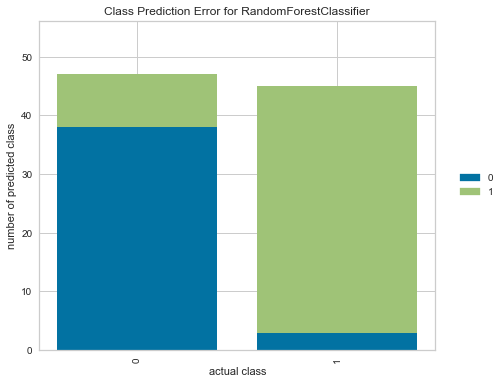

In [246]:
# RF Using PCA
RF_visualizer_using_PCA = ClassPredictionError(Final_RF_model_using_PCA)
RF_visualizer_using_PCA.fit(X_train_after_transformation, y_train_2)
RF_visualizer_using_PCA.score(X_test_after_transformation, y_test_2)
RF_visualizer_using_PCA.poof();

C:\Users\Sandra\.platformio\penv\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



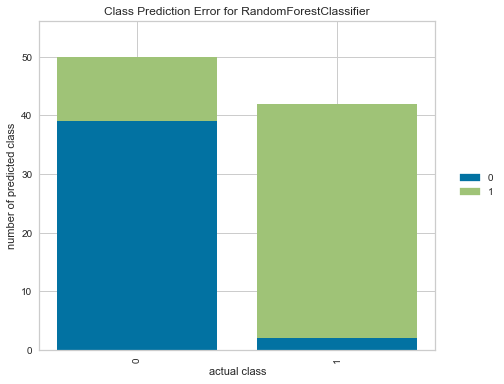

In [247]:
# RF Using SFS
RF_visualizer_using_SFS = ClassPredictionError(Final_RF_model_using_SFS)
RF_visualizer_using_SFS.fit(X_train_for_RF_after_feature_selection, y_train_2)
RF_visualizer_using_SFS.score(X_test_for_RF_after_feature_selection, y_test_2)
RF_visualizer_using_SFS.poof();

### D) Confusion Matrix:

[Text(0, 0.5, 'Heart Disease'), Text(0, 1.5, 'No Disease')]

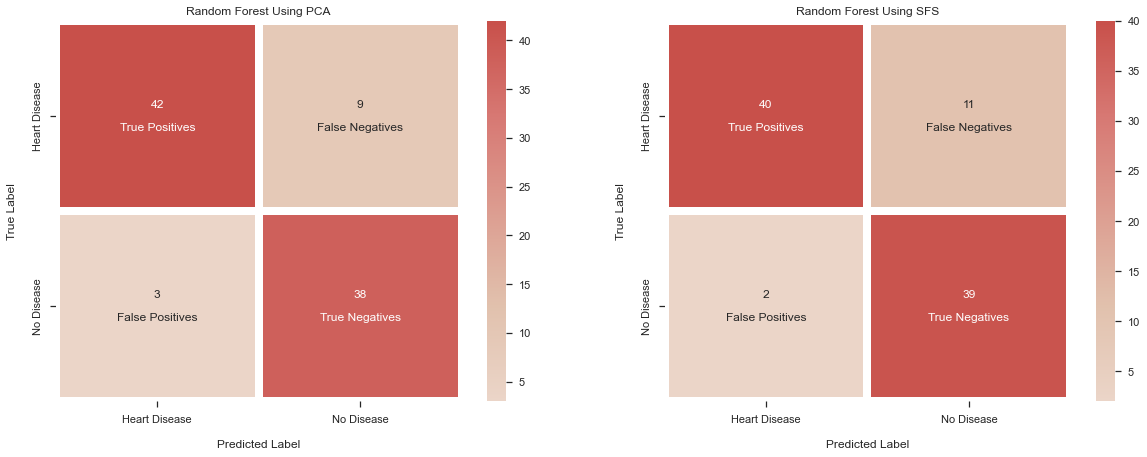

In [266]:
warm=LinearSegmentedColormap.from_list('warm', [(0, '#EBD5C8'), (0.25, '#E1C1AD'), (.75, '#D77873'), (1, '#C8504A')], N=256)

figure, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.subplots_adjust(hspace=0.7)

plt.subplot(1, 2, 1)
cm_1 = confusion_matrix(y_test_2, y_test_pred_RF_using_PCA, labels=[1,0])
classes=['Heart Disease','No Disease']
label = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
annot = [f'{i}\n\n{j}' for i, j in zip(cm_1.flatten(), label)]
annot = np.asarray(annot).reshape(2,2)

sns.set_context('notebook') 
ax = sns.heatmap(cm_1, annot=annot, fmt='', cmap=warm, linecolor='white', linewidths=8)
ax.set_title('Random Forest Using PCA')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label\n')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.subplot(1, 2, 2)
cm_2 = confusion_matrix(y_test_2, y_test_pred_RF_using_SFS, labels=[1,0])
classes=['Heart Disease','No Disease']
label = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
annot = [f'{i}\n\n{j}' for i, j in zip(cm_2.flatten(), label)]
annot = np.asarray(annot).reshape(2,2)

sns.set_context('notebook') 
ax = sns.heatmap(cm_2, annot=annot, fmt='', cmap=warm, linecolor='white', linewidths=8)
ax.set_title('Random Forest Using SFS')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label\n')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)